# Load Data

In [1]:
# Imports
# from settings import *
# import analyze_cascade
import datetime
import pandas as pd
import numpy as np
from itertools import groupby
from collections import Counter
from random import shuffle
from random import choices
import math
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils import plot_model
from IPython.display import Image

Using TensorFlow backend.


In [2]:
#metadata_file = 'metadata_anon.txt' for Nic
metadata_file = '/Users/jaspermeijering/Google Drive/a Study/EPA Study Abroad - Carnegie Mellon University/Courses/CMU - 95845 - Applied Analytics The Machine Learning Pipeline/Machine Learning Pipeline Final Project/Data/FalseNews_Code_Data/data/metadata_anon.txt'


In [3]:
# Read meta data 
fin = open(metadata_file,'r')
lines = fin.readlines()
fin.close()
cascade_id2metadata={}
for line in lines:
    line = line.replace('\n','')
    item = eval(line)
    cascade_id2metadata[item[0]] = item[1]

## Descriptives of dynamic measures

### Static measures

In [4]:
# Get static measures
veracity = []
virality = []
depth = []
breadth = []
size = []
verified = []
nfollowers = []
nfollowees = []
engagement = []
category = []
cascadeID= []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: 
        veracity.append(metadata['veracity'])
        virality.append(metadata['virality'])
        depth.append(metadata['depth'])
        breadth.append(metadata['max_breadth'])
        size.append(metadata['size'])
        verified.append(metadata['verified_list'][0])
        nfollowers.append(metadata['num_followers_list'][0])
        nfollowees.append(metadata['num_followees_list'][0])
        engagement.append(metadata['engagement_list'][0])
        category.append(metadata['rumor_category'])
        cascadeID.append(cascade) # for merging models

# Convert to data frame
df = pd.DataFrame({'cid':cascadeID,'veracity': veracity, 'virality': virality, 'depth': depth, 'breadth': breadth, 'size': size, 'verified': verified, 'nfollowers': nfollowers, 
                   'nfollowees': nfollowees, 'engangement': engagement, 'category': category})

# Inspect
df.head(5)

,breadth,category,cid,depth,engangement,nfollowees,nfollowers,size,veracity,verified,virality
0,10703,Viral Photos/Stories/Urban Legends,106998,11,25.799399,186.0,672.0,23228,MIXED,False,4.003857
1,11783,Science/Nature/Tech/Food/Health,106999,9,10.811974,313.0,380.0,14827,MIXED,False,2.535338
2,6504,Viral Photos/Stories/Urban Legends,107000,13,15.395237,518.0,504.0,14129,MIXED,False,4.019705
3,5772,Viral Photos/Stories/Urban Legends,107001,8,3.140842,189.0,228.0,9972,MIXED,False,3.271008
4,6041,Viral Photos/Stories/Urban Legends,107002,8,5.160261,174.0,110.0,9526,MIXED,False,3.115942


### Dynamic measures

In [5]:
len_depth2time = []
len_num_followees_list = []
len_depth2uu = []
len_uu2time = []
len_depth2breadth = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: 
        len_depth2time.append(len(metadata['depth2time'].keys()))
        len_num_followees_list.append(len(metadata['num_followees_list']))
        len_depth2uu.append(len(metadata['depth2uu'].keys()))
        len_uu2time.append(len(metadata['uu2time'].keys()))
        len_depth2breadth.append(len(metadata['depth2breadth'].keys()))
    
# Convert to data frame
df_len = pd.DataFrame({'depth2time ': len_depth2time, 
                       'num_followees_list': len_num_followees_list, 
                       'depth2uu': len_depth2uu, 
                       'uu2time': len_uu2time, 
                       'depth2breadth': len_depth2breadth})

# # Get summary
df_len.describe(percentiles = [0.25, 0.5, 0.75, 1])
    

,depth2breadth,depth2time,depth2uu,num_followees_list,uu2time
count,42081.000000,42081.000000,42081.000000,42081.000000,42081.000000
mean,1.707707,1.707707,1.707707,93.878829,93.878829
std,1.319555,1.319555,1.319555,950.694376,950.694376
min,1.000000,1.000000,1.000000,2.000000,2.000000
25%,1.000000,1.000000,1.000000,2.000000,2.000000
50%,1.000000,1.000000,1.000000,4.000000,4.000000
75%,2.000000,2.000000,2.000000,9.000000,9.000000
100%,24.000000,24.000000,24.000000,46895.000000,46895.000000
max,24.000000,24.000000,24.000000,46895.000000,46895.000000


## Create LSTM data

### Get dynamic data

In [6]:
# Function to get expression of each item in a dictionary entry
def get_expression_list(entry):
    expression = []
    for i in entry.keys():
        expression.append(float(entry[i]))
    return expression

# Convert y to classification
def veracity_to_categorical(v):
    if v == 'FALSE':
        vbin = [1,0,0]
    elif v == 'MIXED':
        vbin = [0,1,0]
    elif v == 'TRUE':
        vbin = [0,0,1]
    return vbin

# Get data in list format
data = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None:       
        # Get depth
        depth2time = get_expression_list(metadata['depth2time'])
        depth2uu = get_expression_list(metadata['depth2uu'])
        depth2breadth = get_expression_list(metadata['depth2breadth']) 
        veracity = veracity_to_categorical(metadata['veracity'])
        data_id = []
        for time, uu, breadth in zip(depth2time, depth2uu, depth2breadth):
            data_t = [cascade, 
                      veracity,
                      time, uu, breadth]
            data_id.append(data_t)
        data.extend([data_id])

### Preprocessing

In [7]:
# Function: Create training and test set
def split_list(lst, train_size): # train_size is a proportion
    split = len(lst) * train_size
    if split.is_integer():
        split = int(split)
        return lst[:split], lst[split:]
    else:
        split = math.floor(split) + 1
        return lst[:split], lst[split:]
    
# Function: Padding for groups of equal batches
def padding(lst, bsize):
    if len(lst) % bsize != 0:
        psize = bsize - (len(lst) % 5)
        samples = choices(lst, k=psize)
        lst.extend(samples)
    return lst

# Get sublist
def get_sublist(list_in_list, start, stop):
    x = []
    for lst in list_in_list:
        x_id = []
        for sublist in lst:
            if stop is None:
                x_id.append(sublist[start:])
            elif start is None:
                x_id.append(sublist[:stop])
            else:
                x_id.append(sublist[start:stop])
        x.extend([x_id])
    return x

# Separate id, x and y
def separate(list_in_list):
    cid = []
    y = []
    for lst in list_in_list:
        cid.append(lst[0][0]) # only one id is needed
#         veracity_id = []
#         for sublist in lst:
#             veracity_id.extend([sublist[1]])
#         veracity.append(veracity_id)
        y.append(lst[0][1])
    x = get_sublist(list_in_list,2,None)
    return cid, y, x

# # Group by sequence length and append to have batches of 5 for both training and test
data.sort(key=len)   # Randomly reshuffle before? random.shuffle(...)
x_train = []
x_test = []
y_train = []
y_test = []
cid_train = []
cid_test = []
for k, g in groupby(data, len):
    group = list(g)
    if len(group) > 2: # This omits too small groups
        shuffle(group)
        # Create train and test bucket
        train_group, test_group = split_list(group, 0.5)
        # Padd for equal batch size
        train_group_padded = padding(train_group, 5)
        test_group_padded = padding(test_group, 5)
        # Separate list
        cid_train_group, y_train_group, x_train_group = separate(train_group)
        cid_test_group, y_test_group, x_test_group = separate(test_group)
        # Append:  convert y and x into numpy array
        x_train.append(np.array(x_train_group))
        x_test.append(np.array(x_test_group))
        y_train.append(np.array(y_train_group))
        y_test.append(np.array(y_test_group))
        cid_train.append(cid_train_group)
        cid_test.append(cid_test_group)

### Data standardization

In [8]:
# Function to standardize the list
def standardization(lst, index, mean, std):
    for array3d in lst:
        for array2d in array3d:
            for vector in array2d:
                vector[index] = (vector[index] - mean) / std
    return lst

# Function to compute mean and std of variable and then standardizes this variable in list
def standardize_data(a_list, b_list, index):
    var = []
    # Compute mean and std from train data variable
    for array3d in a_list:
        for array2d in array3d:
            for vector in array2d:
                var.append(vector[index])
    var = np.array(var)
    var_mean = var.mean()
    var_std = var.std()
    # Standardize a
    a_list_std = standardization(a_list, index, var_mean, var_std)
    b_list_std = standardization(b_list, index, var_mean, var_std)
    return a_list_std, b_list_std

# Standardize all variables
def standardize_all(a_list, b_list):
    length = len(a_list[0][0][0])
    indices = list(range(length))
    for i in indices:
        std_a, std_b = standardize_data(a_list, b_list, i)
    return std_a, std_b

x_train, x_test = standardize_all(x_train, x_test)

## LSTM train data descriptives

In [9]:
# Group size and sequence length
i = 1
for g in x_train:
    print('Group: ', i, ' ', 'Observations: ', len(g), ' ' 'Sequence length', len(g[0]))
    i += 1

Group:  1   Observations:  12960  Sequence length 1
Group:  2   Observations:  4790  Sequence length 2
Group:  3   Observations:  1790  Sequence length 3
Group:  4   Observations:  760  Sequence length 4
Group:  5   Observations:  320  Sequence length 5
Group:  6   Observations:  170  Sequence length 6
Group:  7   Observations:  95  Sequence length 7
Group:  8   Observations:  65  Sequence length 8
Group:  9   Observations:  35  Sequence length 9
Group:  10   Observations:  25  Sequence length 10
Group:  11   Observations:  20  Sequence length 11
Group:  12   Observations:  15  Sequence length 12
Group:  13   Observations:  10  Sequence length 13
Group:  14   Observations:  10  Sequence length 14
Group:  15   Observations:  5  Sequence length 15
Group:  16   Observations:  5  Sequence length 16
Group:  17   Observations:  5  Sequence length 17
Group:  18   Observations:  5  Sequence length 19


In [10]:
# Convert y to classification
def reverse_veracity_to_categorical(vbin):
    if vbin[0] == 1:
        v = 'FALSE'
    elif vbin[1] == 1:
        v = 'MIXED'
    elif vbin[2] == 1:
        v = 'TRUE'
    return v

# Outcome distribution
i = 1
for g in y_train:
    ver = []
    for y in g:
        ver.append(reverse_veracity_to_categorical(y))
    print('Group: ', i, Counter(ver))
    i += 1

Group:  1 Counter({'FALSE': 9703, 'TRUE': 2005, 'MIXED': 1252})
Group:  2 Counter({'FALSE': 3663, 'TRUE': 679, 'MIXED': 448})
Group:  3 Counter({'FALSE': 1383, 'TRUE': 244, 'MIXED': 163})
Group:  4 Counter({'FALSE': 592, 'TRUE': 109, 'MIXED': 59})
Group:  5 Counter({'FALSE': 251, 'TRUE': 41, 'MIXED': 28})
Group:  6 Counter({'FALSE': 127, 'TRUE': 25, 'MIXED': 18})
Group:  7 Counter({'FALSE': 87, 'TRUE': 5, 'MIXED': 3})
Group:  8 Counter({'FALSE': 52, 'TRUE': 7, 'MIXED': 6})
Group:  9 Counter({'FALSE': 31, 'MIXED': 2, 'TRUE': 2})
Group:  10 Counter({'FALSE': 20, 'MIXED': 4, 'TRUE': 1})
Group:  11 Counter({'FALSE': 20})
Group:  12 Counter({'FALSE': 14, 'TRUE': 1})
Group:  13 Counter({'FALSE': 8, 'MIXED': 2})
Group:  14 Counter({'FALSE': 8, 'MIXED': 2})
Group:  15 Counter({'FALSE': 5})
Group:  16 Counter({'FALSE': 5})
Group:  17 Counter({'FALSE': 5})
Group:  18 Counter({'FALSE': 4, 'MIXED': 1})


## LSTM on dynamic measures

In [11]:
# Create LSTM model
model = Sequential()
model.add(LSTM(5, input_shape = (None, 3),  return_sequences = False))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [12]:
y_train

[array([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        ..., 
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]), array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ..., 
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]), array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ..., 
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]]), array([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        ..., 
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]), array([[1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [

In [13]:
# Fit model and get train predictions
train_pred = []
for X,Y in zip(x_train, y_train):
    hist = model.fit(X, Y, epochs=2, batch_size=5)
    pred = model.predict(X, batch_size=5)
    train_pred.append(pred)

Epoch 1/2
12960/12960 [==============================] - 8s 584us/step - loss: 0.7579 - acc: 0.7474
Epoch 2/2
12960/12960 [==============================] - 8s 615us/step - loss: 0.7320 - acc: 0.7487
Epoch 1/2
4790/4790 [==============================] - 4s 760us/step - loss: 0.7081 - acc: 0.7647
Epoch 2/2
4790/4790 [==============================] - 4s 780us/step - loss: 0.7063 - acc: 0.7647
Epoch 1/2
1790/1790 [==============================] - 2s 942us/step - loss: 0.6904 - acc: 0.7726
Epoch 2/2
1790/1790 [==============================] - 2s 965us/step - loss: 0.6897 - acc: 0.7726
Epoch 1/2
760/760 [==============================] - 1s 1ms/step - loss: 0.6772 - acc: 0.7789
Epoch 2/2
760/760 [==============================] - 1s 1ms/step - loss: 0.6748 - acc: 0.7789
Epoch 1/2
320/320 [==============================] - 0s 1ms/step - loss: 0.6819 - acc: 0.7844
Epoch 2/2
320/320 [==============================] - 0s 1ms/step - loss: 0.6741 - acc: 0.7844
Epoch 1/2
170/170 [=============

In [14]:
# Convert predictions to data frame with ID
cid = []
y1 = []
y2 = []
y3 = []
for pred_group in train_pred:
    for pred in pred_group:
        y1.append(pred[0])
        y2.append(pred[1])
        y3.append(pred[2])
        
for cid_group in cid_train:
    for i in cid_group:
        cid.append(i)

ytrain_pred = pd.DataFrame({'cid': cid, 'y1': y1, 'y2': y2, 'y3': y3})
ytrain_pred = ytrain_pred.drop_duplicates('cid')

In [15]:
len(ytrain_pred)

21042

In [16]:
df_old = df

In [17]:

merged_df = pd.merge(ytrain_pred, df_old, how = 'left',on = 'cid')

In [18]:
df = merged_df
df.head()

,cid,y1,y2,y3,breadth,category,depth,engangement,nfollowees,nfollowers,size,veracity,verified,virality
0,67369,0.737633,0.102950,0.159417,5,War/Terrorism/Shootings,1,325.577912,20670.0,41239.0,5,FALSE,False,1.600000
1,51793,0.739528,0.102038,0.158435,2,Politics,1,29.768926,3836.0,3928.0,2,FALSE,False,1.000000
2,109235,0.738897,0.102341,0.158762,3,Politics,1,27.736943,1013.0,960.0,3,MIXED,False,1.333333
3,55869,0.739528,0.102038,0.158435,2,Business,1,16.749603,307.0,331.0,2,FALSE,False,1.000000
4,86566,0.739528,0.102038,0.158435,2,Viral Photos/Stories/Urban Legends,1,4.046090,128.0,137.0,2,TRUE,False,1.000000


## Categorical and Continious model

In [19]:
df["train_test"] = "train"
df

,cid,y1,y2,y3,breadth,category,depth,engangement,nfollowees,nfollowers,size,veracity,verified,virality,train_test
0,67369,0.737633,0.102950,0.159417,5,War/Terrorism/Shootings,1,325.577912,20670.0,41239.0,5,FALSE,False,1.600000,train
1,51793,0.739528,0.102038,0.158435,2,Politics,1,29.768926,3836.0,3928.0,2,FALSE,False,1.000000,train
2,109235,0.738897,0.102341,0.158762,3,Politics,1,27.736943,1013.0,960.0,3,MIXED,False,1.333333,train
3,55869,0.739528,0.102038,0.158435,2,Business,1,16.749603,307.0,331.0,2,FALSE,False,1.000000,train
4,86566,0.739528,0.102038,0.158435,2,Viral Photos/Stories/Urban Legends,1,4.046090,128.0,137.0,2,TRUE,False,1.000000,train
5,66590,0.737633,0.102950,0.159417,5,Politics,1,325.577912,20670.0,41239.0,5,FALSE,False,1.600000,train
6,61789,0.738897,0.102341,0.158762,3,Politics,1,8.711250,371.0,965.0,3,FALSE,False,1.333333,train
7,63289,0.738897,0.102341,0.158762,3,Science/Nature/Tech/Food/Health,1,137.401393,1105.0,3831.0,3,FALSE,False,1.333333,train
8,85517,0.738265,0.102645,0.159089,4,Politics,1,12.300890,1539.0,1460.0,4,TRUE,False,1.500000,train
9,85644,0.738265,0.102645,0.159089,4,Politics,1,14.074003,2603.0,2361.0,4,TRUE,False,1.500000,train


In [20]:
df_saved = df

In [21]:
df = df_saved

### Pre processing: Make data numeric

In [22]:
# Make category numeric
df["category"] = df["category"].astype('category')
df["category_num"] = df.category.cat.rename_categories([1,2,3,4,5,6,7])
df["category_num"] = df["category_num"].astype('int')
print("Transformed categories to numeric values, this is how they match",df.category.unique(),df.category_num.unique())

# Make veracity numeric
df["veracity"] = df["veracity"].astype('category')
df["veracity_num"] = df.veracity.cat.rename_categories([1,2,3])
df["veracity_num"] = df["veracity_num"].astype('int')
print("Transformed veracity to numeric values, this is how they match",df.veracity.unique(),df.veracity_num.unique())

# Make verified numeric
df["verified_cat"] = df["verified"].astype('category')
df["verified_cat"] = df["verified_cat"].cat.set_categories(["True","False","None"])
#df["verified_cat"].isnull().sum() # 136 nan / none values for verified
#df.loc[df["verified_cat"].isnull(),'verified'] = "None" # -> leave these cascades in. # this is wrong
df["verified_num_pre"] = df.verified_cat.cat.rename_categories([3,2,1])
df["verified_num"] = df["verified_num_pre"].astype('int')
print("Transformed verified to numeric values, this is how they match",df.verified.unique(),df.verified_num.unique())


Transformed categories to numeric values, this is how they match [War/Terrorism/Shootings, Politics, Business, Viral Photos/Stories/Urban Legends, Science/Nature/Tech/Food/Health, Entertainment, Natural Disasters]
Categories (7, object): [War/Terrorism/Shootings, Politics, Business, Viral Photos/Stories/Urban Legends, Science/Nature/Tech/Food/Health, Entertainment, Natural Disasters] [7 4 1 6 5 2 3]
Transformed veracity to numeric values, this is how they match [FALSE, MIXED, TRUE]
Categories (3, object): [FALSE, MIXED, TRUE] [1 2 3]
Transformed verified to numeric values, this is how they match [False True None] [-9223372036854775808]


### Only keep relevant columns

In [23]:
# Only keep relevant columns
column_names_df = ['cid','y1','y2','y3','veracity_num','breadth', 'category_num', 'depth', 'engangement','nfollowees', 'nfollowers', 'size', 'verified_num', 'virality','train_test']
column_names_x =['cid','y1','y2','y3','breadth', 'category_num', 'depth', 'engangement','nfollowees', 'nfollowers', 'size', 'verified_num', 'virality']
column_names_x_cat = ['category_num','verified_num']  # add cid?
column_names_x_con = ['y1','y2','y3','breadth', 'depth', 'engangement', 'nfollowees', 'nfollowers', 'size', 'virality'] #add cid
column_names_y =['veracity_num','cid'] # ['cid','veracity_num']

df = df.loc[:,column_names_df]
df.head()


,cid,y1,y2,y3,veracity_num,breadth,category_num,depth,engangement,nfollowees,nfollowers,size,verified_num,virality,train_test
0,67369,0.737633,0.102950,0.159417,1,5,7,1,325.577912,20670.0,41239.0,5,-9223372036854775808,1.600000,train
1,51793,0.739528,0.102038,0.158435,1,2,4,1,29.768926,3836.0,3928.0,2,-9223372036854775808,1.000000,train
2,109235,0.738897,0.102341,0.158762,2,3,4,1,27.736943,1013.0,960.0,3,-9223372036854775808,1.333333,train
3,55869,0.739528,0.102038,0.158435,1,2,1,1,16.749603,307.0,331.0,2,-9223372036854775808,1.000000,train
4,86566,0.739528,0.102038,0.158435,3,2,6,1,4.046090,128.0,137.0,2,-9223372036854775808,1.000000,train


In [24]:
X_train_cat  = df.loc[df["train_test"] == "train",column_names_x_cat ]
X_test_cat  = df.loc[df["train_test"] == "test",column_names_x_cat ]
X_train_con  = df.loc[df["train_test"] == "train",column_names_x_con ]
X_test_con  = df.loc[df["train_test"] == "test",column_names_x_con ]
Y_train = df.loc[df["train_test"] == "train",column_names_y ]
Y_test = df.loc[df["train_test"] == "test",column_names_y ]

In [25]:
save_Y_train = df.loc[df["train_test"] == "train",column_names_y ]
save_Y_test = df.loc[df["train_test"] == "train",column_names_y ]
save_Y_train.head(3)

,veracity_num,cid
0,1,67369
1,1,51793
2,2,109235


In [26]:
save_Y_train.head(10)
def change_formatY(save_Y_train):
    save_Y_train.index = np.arange(1, len(save_Y_train) + 1)
    for a in range(3):
        save_Y_train["Y_input_%d"% (a+1)] = 0
    for i in range(len(save_Y_train)):
        for j in range(4):
            if save_Y_train.iloc[i,0] == j:
                save_Y_train["Y_input_%d"% (j)][i+1] = 1
                break
    return(save_Y_train.iloc[:,1:])

In [30]:
Y_train = change_formatY(save_Y_train)
Y_test = change_formatY(save_Y_test)
Y_train = Y_train.loc[:,['Y_input_1','Y_input_2','Y_input_3']] # without CID
Y_test = Y_test.loc[:,['Y_input_1','Y_input_2','Y_input_3']] # without CID
Y_test.head(3)

,Y_input_1,Y_input_2,Y_input_3
1,1,0,0
2,1,0,0
3,0,1,0


In [33]:
def change_formatX(X_train_cat):
    X_train_cat.index = np.arange(1, len(X_train_cat) + 1)
    for a in range(7):
        X_train_cat["category_num_%d"% (a+1)] = 0
    #for b in range(31):
     #   X_train_cat["day_%d"% (b+1)] = 0
   # for c in range(3):
   #     X_train_cat["verified_%d"% (c+1)] = 0
    
    for i in range(len(X_train_cat)):
        for j in range(8):
            if X_train_cat.iloc[i,0] == j:
                X_train_cat["category_num_%d"% (j)][i+1] = 1
                break
    #    for k in range(32):
     #       if X_train_cat.iloc[i,1] == k:
      #          X_train_cat["day_%d"% (k)][i+1] = 1
       #         break
      #  for l in range(4):
     #       if X_train_cat.iloc[i,2] == l:
     #           X_train_cat["verified_%d"% (l)][i+1] = 1
     #           break     
    return X_train_cat

In [34]:
X_train_cat2 = change_formatX(X_train_cat)
X_test_cat2 = change_formatX(X_test_cat)

In [35]:
# Run this block only once (or in combination with the block above)
X_train_cat2 = X_train_cat2.iloc[:,3:] # [:,4:] for dataframe without cid [:,3:] for dataframe with cid 
X_test_cat2 = X_test_cat2.iloc[:,3:] # [:,4:] for dataframe without cid
X_train_cat2.head()

,category_num_2,category_num_3,category_num_4,category_num_5,category_num_6,category_num_7,verified_1,verified_2,verified_3
1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0


In [36]:
#Normalize continious data ONLY RUN ONCE
X_train_con = np.log(X_train_con.iloc[:,:]+1)
X_test_con = np.log(X_test_con.iloc[:,:]+1)   


In [37]:
# Change datastructue df -> matrix
X_train_cat  = X_train_cat2.as_matrix()
X_test_cat = X_test_cat2.as_matrix() 
X_train_con  = X_train_con.as_matrix()
X_test_con = X_test_con.as_matrix()
Y_train = Y_train.as_matrix()
Y_test = Y_test.as_matrix()

# Categorical model

In [39]:

from keras.layers import Input, Dense
from keras.models import Model
# This returns a tensor
inputs = Input(shape=(9,)) # 10 with verified

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(4, activation='relu')(inputs)
x = Dense(4, activation='relu')(x)
x = Dense(4, activation='tanh')(x)
predictions = Dense(3, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_cat_new = Model(inputs=inputs, outputs=predictions)
model_cat_new.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mse','accuracy']) #accuracy
model_cat_new.fit(X_train_cat, Y_train,epochs=10) 

Epoch 1/10
21042/21042 [==============================] - 1s 69us/step - loss: 0.7146 - mean_squared_error: 0.1327 - acc: 0.7566
Epoch 2/10
21042/21042 [==============================] - 1s 54us/step - loss: 0.6865 - mean_squared_error: 0.1270 - acc: 0.7576
Epoch 3/10
21042/21042 [==============================] - 1s 56us/step - loss: 0.6806 - mean_squared_error: 0.1260 - acc: 0.7576
Epoch 4/10
21042/21042 [==============================] - 1s 51us/step - loss: 0.6781 - mean_squared_error: 0.1257 - acc: 0.7576
Epoch 5/10
21042/21042 [==============================] - 1s 53us/step - loss: 0.6769 - mean_squared_error: 0.1255 - acc: 0.7576
Epoch 6/10
21042/21042 [==============================] - 1s 53us/step - loss: 0.6766 - mean_squared_error: 0.1255 - acc: 0.7576
Epoch 7/10
21042/21042 [==============================] - 1s 60us/step - loss: 0.6762 - mean_squared_error: 0.1255 - acc: 0.7576
Epoch 8/10
21042/21042 [==============================] - 1s 55us/step - loss: 0.6760 - mean_squa

In [40]:
model_cat_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 15        
Total params: 95
Trainable params: 95
Non-trainable params: 0
_________________________________________________________________


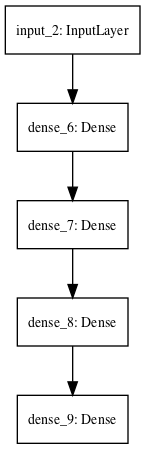

In [41]:
# save model as image
plot_model(model_cat_new, to_file='Images/model_cat_new.png')
Image("Images/model_cat_new.png")

In [ ]:
# Continuous

In [42]:
model_con = Sequential()

model_con.add(Dense(4,input_dim = 10,activation = 'relu')) 

model_con.add(Dense(40, activation = 'tanh' ))
model_con.add(Dense(40, activation = 'relu' ))
model_con.add(Dense(3, activation = 'softmax' ))

model_con.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
plot_model(model_con, to_file='Images/model_con.png')
Image("Images/model_con.png")


In [43]:
model_con.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4)                 44        
_________________________________________________________________
dense_11 (Dense)             (None, 40)                200       
_________________________________________________________________
dense_12 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 123       
Total params: 2,007
Trainable params: 2,007
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_con.fit(X_train_con, Y_train,
          epochs=20,
          batch_size=128
         )

Epoch 1/20
21042/21042 [==============================] - 1s 33us/step - loss: nan - acc: 0.7534
Epoch 2/20
21042/21042 [==============================] - 0s 13us/step - loss: nan - acc: 0.7576
Epoch 3/20
21042/21042 [==============================] - 0s 14us/step - loss: nan - acc: 0.7576
Epoch 4/20
21042/21042 [==============================] - 0s 15us/step - loss: nan - acc: 0.7576
Epoch 5/20
21042/21042 [==============================] - 0s 13us/step - loss: nan - acc: 0.7576
Epoch 6/20
21042/21042 [==============================] - 0s 14us/step - loss: nan - acc: 0.7576
Epoch 7/20
21042/21042 [==============================] - 0s 16us/step - loss: nan - acc: 0.7576
Epoch 8/20
21042/21042 [==============================] - 0s 14us/step - loss: nan - acc: 0.7576
Epoch 9/20
21042/21042 [==============================] - 0s 13us/step - loss: nan - acc: 0.7576
Epoch 10/20
21042/21042 [==============================] - 0s 14us/step - loss: nan - acc: 0.7576
Epoch 11/20
21042/21042 [====

In [45]:
# Get test_set from Nic
#score_con = model_con.evaluate(X_test_con, Y_test, batch_size=128)
score_con = model_con.evaluate(X_train_con, Y_train, batch_size=128)
score_con[1]

21042/21042 [==============================] - 0s 8us/step


0.75762760188232614

In [57]:
cat_input = Input(shape=(9,), name='Categorial_input')  #10 with verified
con_input = Input(shape=(10,), name='Continous_input')

#lstm_input = ??

x = keras.layers.concatenate([cat_input, con_input])
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(3, activation='softmax', name='main_output')(x) 

In [58]:
model_total = Model(inputs=[cat_input, con_input], outputs=[main_output])

In [59]:
model_total.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorial_input (InputLayer)   (None, 9)            0                                            
__________________________________________________________________________________________________
Continous_input (InputLayer)    (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 19)           0           Categorial_input[0][0]           
                                                                 Continous_input[0][0]            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 64)           1280        concatenate_3[0][0]              
__________

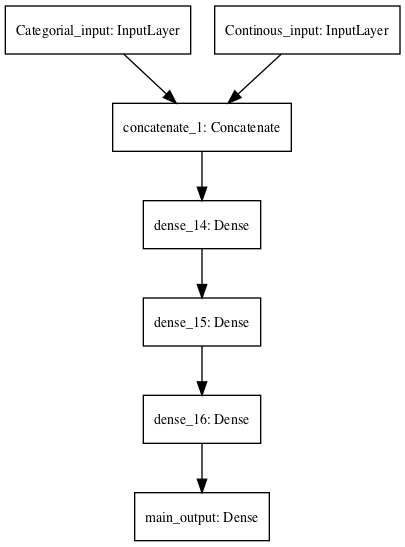

In [49]:
plot_model(model_total, to_file='Images/model_combined.png')
from IPython.display import Image
Image("Images/model_combined.png")


In [60]:
model_total.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['mse','accuracy'])

In [61]:
model_total.fit([X_train_cat, X_train_con], Y_train,
          epochs=20, batch_size=32)

Epoch 1/20
21042/21042 [==============================] - 2s 78us/step - loss: nan - mean_squared_error: nan - acc: 0.7575
Epoch 2/20
21042/21042 [==============================] - 1s 59us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 3/20
21042/21042 [==============================] - 1s 59us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 4/20
21042/21042 [==============================] - 1s 55us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 5/20
21042/21042 [==============================] - 1s 57us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 6/20
21042/21042 [==============================] - 1s 58us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 7/20
21042/21042 [==============================] - 1s 58us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 8/20
21042/21042 [==============================] - 1s 57us/step - loss: nan - mean_squared_error: nan - acc: 0.7576
Epoch 9/20
21042

In [ ]:
# Get test_set from Nic
#score_total = model_total.evaluate(  )
#score_total

# Evaluation

In [62]:

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [71]:
X_train_cat[1].shape
#X_train_con[1].shape
#X_train_con[2]

(9,)

In [80]:
#model_total.predict([X_train_cat,X_train_con])

model_total.predict([X_train_cat[2],X_train_con[2]])
#model_total.predict([[X_train_cat[2]],X_train_con[2]])

#model_total.predict(0, 0, 0, 1, 0, 0, 0, 0, 0, 0,[ 0.56294174,  0.08946883,  0.14026323,  1.38629436,  0.69314718,
    #    2.80746823,  7.02108396,  7.28687641,  1.38629436,  0.84729786])

#model_total.predict([X_train_cat[10:20],X_train_con[10:20]]) # does work, why does is needs to be 10 by 10?
# it should out put a array of 3 not of 3 by 10. 

ValueError: Error when checking : expected Categorial_input to have shape (9,) but got array with shape (1,)

In [ ]:
# to calculate the roc curve you need: roc_curve(Y_train[:, i], score_con[1]).
# the score per row, we don't have that. But can calculate it by doing a prediction. 
#The predicion though doens't work.
#




# it needs an input of 10 by 10 instead of 9 and 10
#when you feed it 10 by 10 you only get nan (so maybe you don't neeed 10 by 10?)


In [ ]:
score_con[1], Y_train[:, 1]

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    fpr[i], tpr[i], _ = roc_curve(Y_train[:, i], score_con[1]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()